# Raster dataset

In [ ]:
# Install Required Libraries

!pip install rasterio geopandas matplotlib


In [ ]:
# Import libraries

import rasterio
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Open and Read the Raster File

raster_path = '/content/sample_data/Raster.tif'

with rasterio.open(raster_path) as src:
    raster = src.read(1)  # Read the first band
    profile = src.profile
    bounds = src.bounds


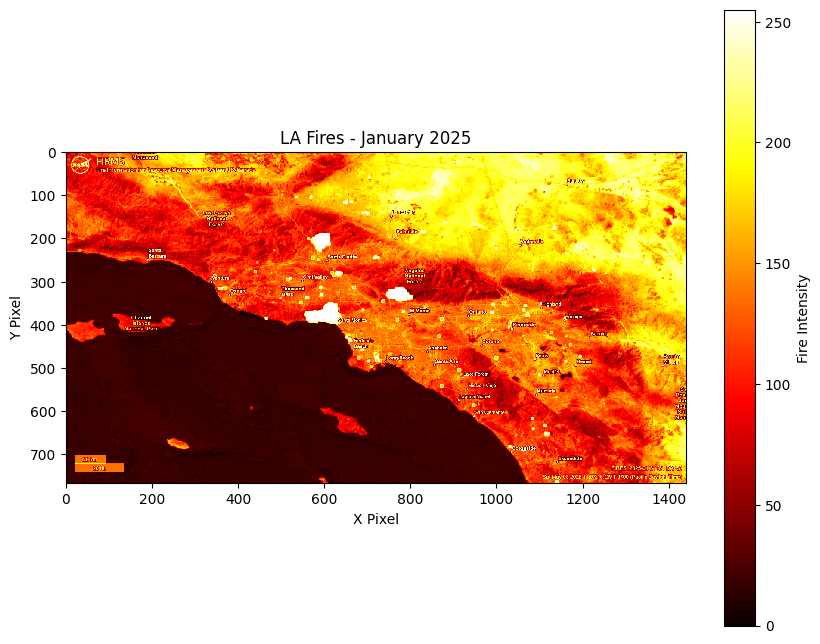

In [ ]:
# Display the Raster Data

## import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(raster, cmap='hot', interpolation='none')
plt.colorbar(label='Fire Intensity')
plt.title('LA Fires - January 2025')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


The lighter the color, the more intense the fires are. As you can see in the plot above, there are 3 clusters in Los Angeles that saw the greatest fire intensity. Those places are Santa Clarita (by Castaic Lake), on the coast which we know today as the Pacific Palisades fires, and Altadena (near the Eaton Canyon Trail).

This plot answers our research question(s) because it shows zones that are prone to very intense fires. This is important because if another event like this were to happen again, lots of resources would need to go to these specific areas.

In [ ]:
# Extract and Print Metadata

print("Raster metadata:")
print(f"Width: {profile['width']}")
print(f"Height: {profile['height']}")
print(f"CRS: {profile['crs']}")
print(f"Bounds: {bounds}")

Raster metadata:
Width: 1440
Height: 768
CRS: EPSG:4326
Bounds: BoundingBox(left=-120.2208830625, bottom=32.9975505, right=-116.2658049375, top=35.1069255)


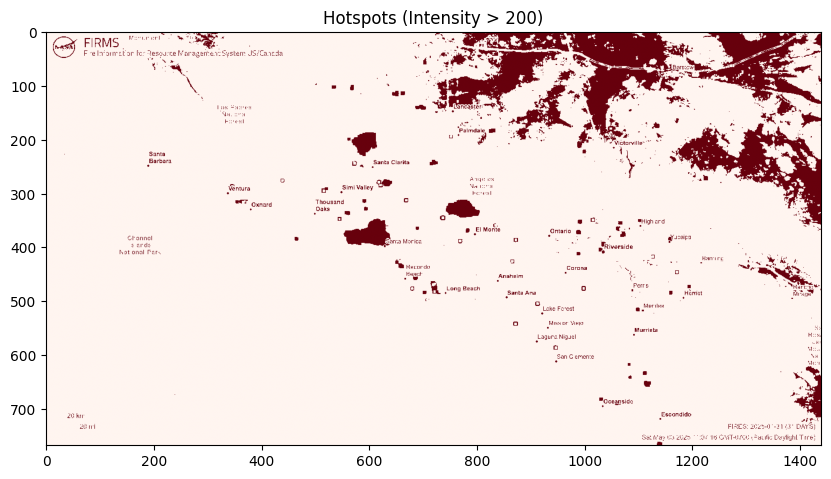

In [ ]:
# Analyze Burn Intensity or Hotspots

## Example: Highlight values greater than 200
threshold = 200
hotspots = np.where(raster > threshold, 1, 0)

plt.figure(figsize=(10, 8))
plt.imshow(hotspots, cmap='Reds')
plt.title(f'Hotspots (Intensity > {threshold})')
plt.show()

The plot above is another way of visualizing the hotspots that we saw in the first plot. The locations in dark red are places with a fire intensity greater than 200.

In [ ]:
# Extract Lat/Lon of Hotspots

import rasterio
import numpy as np
import pandas as pd
from rasterio.transform import xy

# Open raster file
raster_path = '/content/sample_data/Raster.tif'
threshold = 200  # Set your intensity threshold

with rasterio.open(raster_path) as src:
    raster = src.read(1)  # First band
    transform = src.transform

    # Get row, col indices of pixels above threshold
    rows, cols = np.where(raster > threshold)

    # Convert pixel indices to lat/lon
    lons, lats = zip(*[xy(transform, r, c) for r, c in zip(rows, cols)])

# Create DataFrame of hotspot coordinates
hotspot_df = pd.DataFrame({
    'latitude': lats,
    'longitude': lons,
    'intensity': raster[rows, cols]
})

# Show a few rows
hotspot_df


,latitude,longitude,intensity
0,35.105552,-119.769070,221
1,35.105552,-119.763577,209
2,35.105552,-119.752591,206
3,35.105552,-119.749844,221
4,35.105552,-119.744351,222
...,...,...,...
94839,32.998924,-117.088406,234
94840,32.998924,-117.085660,226
94841,32.998924,-117.082913,228
94842,32.998924,-117.080167,225


This dataframe gives us the latitude, longitude, and fire intensity of each point in our data frame with an intensity greater than 200. Using this dataframe, we would be able to find which clusters were more intense than others with a statistical approach.

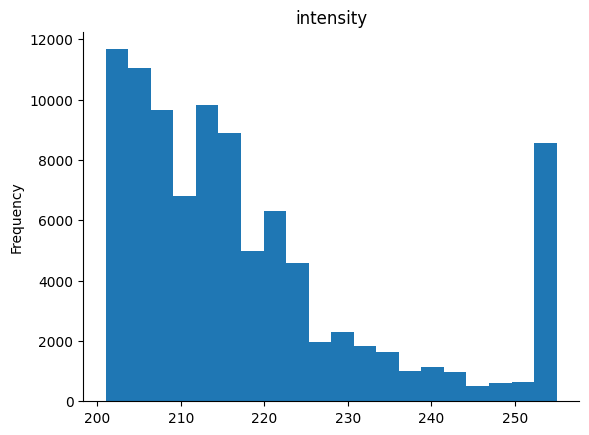

In [ ]:
from matplotlib import pyplot as plt
hotspot_df['intensity'].plot(kind='hist', bins=20, title='intensity')
plt.gca().spines[['top', 'right',]].set_visible(False)

This graph shows the distribution of fire intensities over 200. As we can see, most of the intensities are close to 200 whereas there are some intensities over 250. We can use 250 as a threshold to see if a certain cluster was received more intense fires than another.

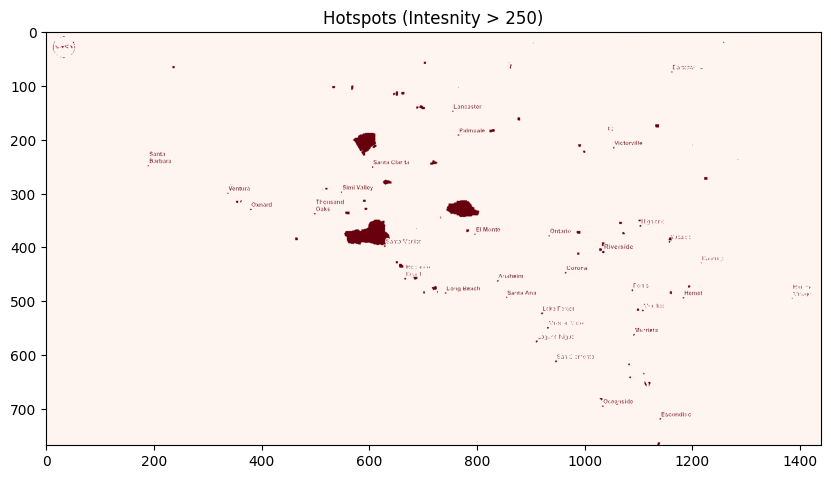

In [ ]:
# Analyze Burn Intensity or Hotspots

## Example: Highlight values greater than 250
threshold = 250
hotspots = np.where(raster > threshold, 1, 0)

plt.figure(figsize=(10, 8))
plt.imshow(hotspots, cmap='Reds')
plt.title(f'Hotspots (Intesnity > {threshold})')
plt.show()

I decided to run the threshold plot from earlier but with 250 instead of 200. I wanted to see if some clusters were hit worse than others, but it appears that each cluster dealt with really intense fires.

# Vector Dataset

This dataset only focuses on the Altadena cluster that was highlighted earlier.

In [22]:
!pip install geopandas pyproj


In [24]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the CSV
vector_df = pd.read_csv('/content/sample_data/Vector.csv')

# Create geometry column from X and Y
geometry = [Point(xy) for xy in zip(vector_df['X'], vector_df['Y'])]

# Create GeoDataFrame with EPSG:3857 (Web Mercator)
gdf = gpd.GeoDataFrame(vector_df, geometry=geometry, crs="EPSG:3857")

# Reproject to EPSG:4326 (lat/lon)
gdf = gdf.to_crs(epsg=4326)

# Extract lat/lon into new columns
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

# Create new dataset called filter_data
filter_data = gdf[['OBJECTID', 'latitude', 'longitude', 'DAMAGE', 'STRUCTURETYPE']]
filter_data


,OBJECTID,latitude,longitude,DAMAGE,STRUCTURETYPE
0,1,34.174979,-118.097537,No Damage,Single Family Residence Multi Story
1,2,34.185656,-118.113342,No Damage,Single Family Residence Multi Story
2,3,34.185697,-118.113560,Affected (1-9%),Single Family Residence Single Story
3,4,34.174981,-118.097720,No Damage,Utility Misc Structure
4,5,34.175060,-118.097493,No Damage,Single Family Residence Single Story
...,...,...,...,...,...
18421,18621,34.194266,-118.159774,Destroyed (>50%),Utility Misc Structure
18422,18622,34.188726,-118.148681,Destroyed (>50%),Utility Misc Structure
18423,18623,34.205674,-118.133403,Destroyed (>50%),Utility Misc Structure
18424,18624,34.173142,-118.057728,Destroyed (>50%),Utility Misc Structure


In [25]:
filter_data.groupby('DAMAGE').size()

,0
DAMAGE,
Affected (1-9%),857
Destroyed (>50%),9418
Inaccessible,40
Major (26-50%),70
Minor (10-25%),148
No Damage,7893


This table shows the damage to each structure in our vector dataset. As we can see over half of the structures in our dataset were destoryed while there were also many that recieved no damage.

In [26]:
filter_data.groupby('STRUCTURETYPE').size()

,0
STRUCTURETYPE,
Church,21
Commercial Building Multi Story,54
Commercial Building Single Story,216
Hospital,2
Infrastructure,102
Mixed Commercial/Residential,13
Mobile Home Double Wide,4
Mobile Home Single Wide,6
Motor Home,10


This table shows the many different structure types in our dataset. As we can see the structures ranges from churches to hospitals to motor homes to schools. Over half of the structures in our dataset are labeled as 'Single Family Residence Single Story', which simply means a one-story house.

This table answers the research question(s) because it shows what populations are most affected by the wildfires. Single-family homes make up a majority of the structures in this dataset, so those who live in these structures are most affected.

In [27]:
# Group by STRUCTURETYPE and DAMAGE, then sort by count descending
grouped = (
    filter_data.groupby(['STRUCTURETYPE', 'DAMAGE'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

# Show the top of the sorted table
print(grouped.head())


                           STRUCTURETYPE            DAMAGE  count
48  Single Family Residence Single Story  Destroyed (>50%)   5160
52  Single Family Residence Single Story         No Damage   3672
54                Utility Misc Structure  Destroyed (>50%)   3137
58                Utility Misc Structure         No Damage   2299
46   Single Family Residence Multi Story         No Damage   1410


The table above shows the most common structure type and the damage that was done to it. As we can see the most common combination was a one-story house that was destroyed.

This once again answers the question of what populations are affected the most by the wildfires. This table shows that more than half of the one-story homes in our dataset were destroyed.

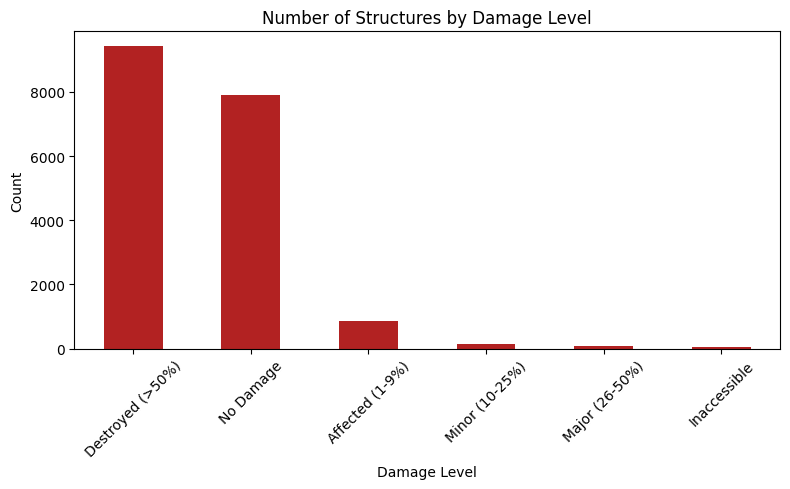

In [28]:
import matplotlib.pyplot as plt

filter_data['DAMAGE'].value_counts().plot(kind='bar', color='firebrick', figsize=(8, 5))
plt.title('Number of Structures by Damage Level')
plt.xlabel('Damage Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This plot is another way of showing the number of structures by damage level. As we can see most of the structures in our dataset were destroyed.

<ipython-input-29-440e67dd8c85>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['geometry'] = [Point(xy) for xy in zip(filter_data['longitude'], filter_data['latitude'])]


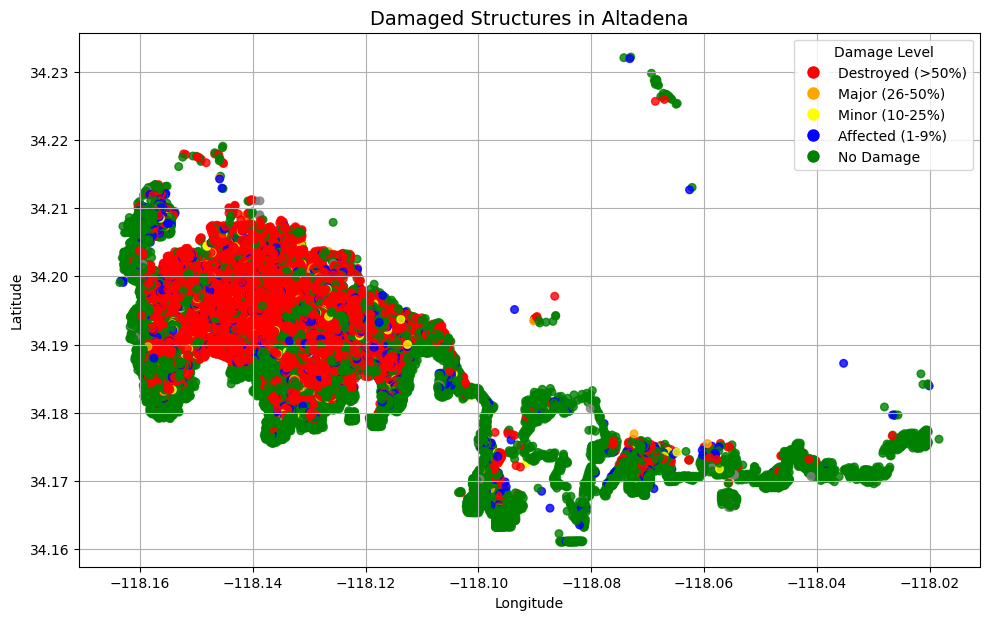

In [29]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Create geometry again just to be safe
from shapely.geometry import Point
filter_data['geometry'] = [Point(xy) for xy in zip(filter_data['longitude'], filter_data['latitude'])]
gdf = gpd.GeoDataFrame(filter_data, geometry=filter_data['geometry'], crs='EPSG:4326')

# Define colors for each damage level
damage_colors = {
    'Destroyed (>50%)': 'red',
    'Major (26-50%)': 'orange',
    'Minor (10-25%)': 'yellow',
    'Affected (1-9%)': 'blue',
    'No Damage': 'green'
}
gdf['color'] = gdf['DAMAGE'].map(damage_colors).fillna('gray')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=gdf['color'], markersize=30, alpha=0.8)

# Add title and legend
plt.title('Damaged Structures in Altadena', fontsize=14)
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', label=key,
                            markerfacecolor=value, markersize=10)
                 for key, value in damage_colors.items()]
plt.legend(handles=legend_labels, title='Damage Level')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.tight_layout()
plt.show()


The plot above shows the location of our structures and how much damage was done to them. As we can see, most of the structures in our dataset are located in the southwest portion of the Altadena cluster. This makes sense when we realize that the Eaton Canyon trail is located next to Altadena, so very few structures will be placed in the northeast part of our plot. We can also see that a lot of these structures were either destroyed or saw no damage at all.

This answers what areas of Los Angeles are fire-prone and what population of people are disproportionately affected. This plot may be used to change the response in environmental and urban planning.

# Socioeconomic dataset

In [18]:
import pandas as pd

# Load the dataset
socio = pd.read_csv('/content/sample_data/Socio.csv')  # or adjust the path if needed

# Preview the data
socio.head()


,City,State,ZIP,PriceBefore,PriceAfter,DateOfIncrease,ListingSite,ListingAgent,PropertyOwner,ParcelID
0,Santa Monica,CA,90045,"$12,750.00","$28,000.00",1/10/2025,Zillow,Gabriel Palmrot; Westside Estate Agency Inc.,NaN,4272007003
1,Los Angeles,Ca,90064,"$5,000.00","$7,000.00",1/11/2025,Zillow,NaN,Selia Hao,4260028003
2,Los Angeles,CA,90049,"$8,995.00","$12,000.00",1/10/2025,Zillow,NaN,M Joseph,4494010023
3,Los Angeles,CA,90026,"$9,000.00","$11,000.00",1/11/2025,Zillow,NaN,Edward Kay,5429020022
4,Los Angeles,CA,90069,"$8,500.00","$11,500.00",1/9/2025,Zillow,Mark Bua; Keller Williams Studio City,NaN,5560025007


In [19]:
# Clean currency columns: remove $ and commas, convert to float
# Extract numeric values using regular expressions
socio['PriceBefore'] = socio['PriceBefore'].str.extract(r'(\d+)').astype(float)  # Extracts the first sequence of digits
socio['PriceAfter'] = socio['PriceAfter'].str.extract(r'(\d+)').astype(float)  # Extracts the first sequence of digits

# Convert date column to datetime
socio['DateOfIncrease'] = pd.to_datetime(socio['DateOfIncrease'], format='%m/%d/%Y', errors='coerce')  # Added errors='coerce' to handle potential errors during conversion

# Calculate absolute and percentage price increase
socio['PriceChange'] = socio['PriceAfter'] - socio['PriceBefore']
socio['PercentIncrease'] = (socio['PriceChange'] / socio['PriceBefore']) * 100

In [20]:
# Top 5 listings with highest % increase
top_gouges = socio.sort_values(by='PercentIncrease', ascending=False).head(5)
print(top_gouges[['City', 'ZIP', 'PriceBefore', 'PriceAfter', 'PercentIncrease']])


               City    ZIP  PriceBefore  PriceAfter  PercentIncrease
289   Beverly Hills  90210          1.0        65.0           6400.0
1433       Glendale  91208          1.0        28.0           2700.0
283     Los Angeles  90046          1.0        25.0           2400.0
865      West Hills  91304          1.0        25.0           2400.0
422      West Hills  91304          1.0        25.0           2400.0


In [35]:
# Average increase by ZIP code
avg_by_zip = socio.groupby('ZIP')['PercentIncrease'].mean().sort_values(ascending=False)
print(avg_by_zip.head())

ZIP
90631    1600.000000
91208    1359.090909
91028    1300.000000
90245     700.000000
91773     600.000000
Name: PercentIncrease, dtype: float64


The table above shows the ZIP codes that had the greatest percentage increases in rent.

This shows populations that are disproportionately affected as the people in these areas are being gouged out due to landlords increasing rents.

In [36]:
# Average increase by City
avg_by_City = socio.groupby('City')['PercentIncrease'].mean().sort_values(ascending=False)
print(avg_by_City.head())

City
La Habra Heights    1600.0
 Los Angeles        1500.0
Reseda              1000.0
El Segundo           700.0
San Dimas            600.0
Name: PercentIncrease, dtype: float64


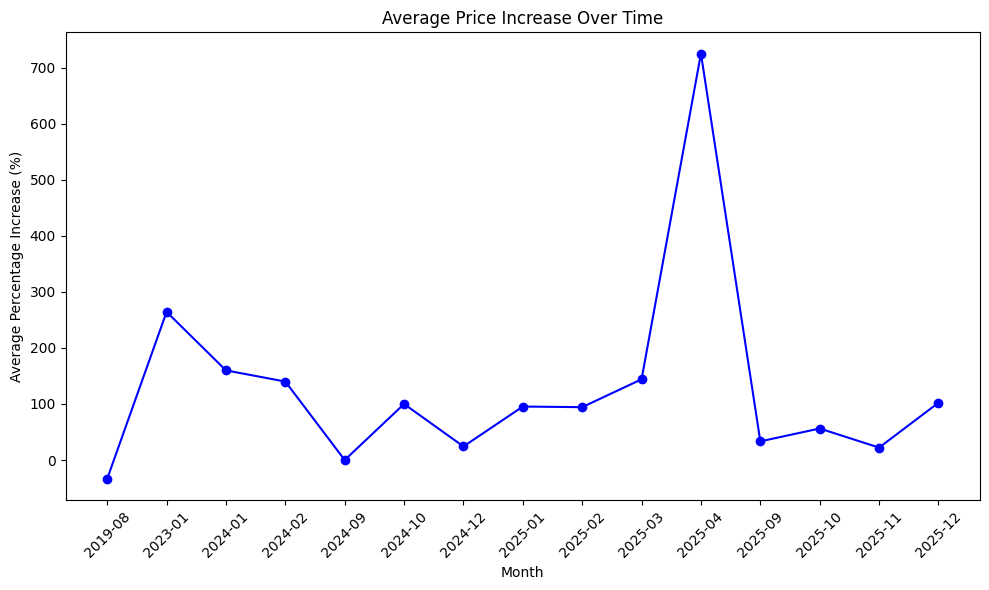

In [38]:
# Extract year and month for time-based grouping
socio['YearMonth'] = socio['DateOfIncrease'].dt.to_period('M')

# Calculate the average percentage increase per month
monthly_trends = socio.groupby('YearMonth')['PercentIncrease'].mean().reset_index()

# Plot the time trend
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(monthly_trends['YearMonth'].astype(str), monthly_trends['PercentIncrease'], marker='o', linestyle='-', color='b')
plt.title('Average Price Increase Over Time')
plt.xlabel('Month')
plt.ylabel('Average Percentage Increase (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot above shows us the average percentage increase over time. As we can see the average percentage spikes just a few months after the wildfires.

This shows how vulnerable populations are disproportionately affected. Renters are being priced gouged out of their apartments and their cost of living is increasing exponentially. When it comes to urban planning, Governor Gavin Newsom issued an executive order in February 2025 expanding protections related to rental housing price gouging. He then extended the rent cap just a month later. This is a prime example of how politicians can protect their constituents from evergrowing circumstances and increases on cost of living.